In [21]:
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
from matplotlib.animation import FuncAnimation, PillowWriter
import itertools
from scipy.stats import linregress
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.interpolate import interp1d

In [2]:
mpl.rcParams.update(mpl.rcParamsDefault)
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Times"] + plt.rcParams["font.serif"]
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['mathtext.rm'] = 'Serif'
mpl.rcParams['mathtext.it'] = 'Serif'
mpl.rcParams['mathtext.bf'] = 'Serif'
mpl.rcParams['text.usetex']= False
plt.rc('axes', linewidth=2)
plt.rc('font', weight='bold')

In [3]:
def get_data(logs_dir):
    freqs = []
    profs = []
    n_profs = []
    # prof_index = pd.read_table(f"{logs_dir}/profiles.index", skiprows=1, sep='\s+')
    prof_index = np.loadtxt(f"{logs_dir}/profiles.index", skiprows=1, dtype=int)

    for f in sorted(glob.glob(f"{logs_dir}/profile*.data.GYRE"), 
                    key=lambda x: int(os.path.basename(x).split('.')[0].split('profile')[1])):
        profs.append(pd.read_table(f, skiprows=5, sep='\s+'))

    for f in sorted(glob.glob(f"{logs_dir}/profile*-freqs.dat"), 
                    key=lambda x: int(os.path.basename(x).split('.')[0].split('profile')[1].split('-')[0])):
        freqs.append(pd.read_table(f, skiprows=5, sep='\s+'))
        n_profs.append(int(f.split('profile')[-1].split('-')[0]))
    hist = pd.read_table(glob.glob(f"{logs_dir}/history.data")[0], skiprows=5, sep='\s+')

    return hist, freqs, profs, n_profs, prof_index

# hist, freqs, profs, n_profs, prof_index = get_data("tests_here/test_M1.5_Z0.01/LOGS")
# n_profs

In [4]:
def fit_radial(ts, degree=0):
    """
    Fits a straight line to the radial mode frequencies. Optionally, can be used on non-radial modes.
    Only modes with radial orders 5-9 are used, as the ridges should be vertical here.
    
    Input: Theoretical (or observed) spectrum in pandas df format; mode degree to be used (default 0 = radial)
    Output: The length of the series used, and the slope, intercept, r_value, p_value, and std_err of the line.
    """
    n_min, n_max = 5, 9
    try:
        vert_freqs = ts.query("n_g == 0").query(f"l=={degree}").query(f"n_pg>={n_min}").query(f"n_pg<={n_max}")[["n_pg","Re(freq)"]].values
    except:
        vert_freqs = ts.query(f"l_obs=={degree}").query(f"n_obs>={n_min}").query(f"n_obs<={n_max}")[["n_obs","f_obs"]].values
    if len(vert_freqs>0):
        slope, intercept, r_value, p_value, std_err = linregress(vert_freqs[:,0], vert_freqs[:,1])
    else:
        slope, intercept, r_value, p_value, std_err = np.zeros(5)
    return len(vert_freqs), slope, intercept, r_value, p_value, std_err

def model_epsilon(ts):
    """
    Calls the fit_radial function to determine the epsilon value for a star's pulsations.
    
    Input: Theoretical (or observed) spectrum in pandas df format.
    Output: Epsilon
    """
    length_rad, slope, intercept, r_value, p_value, std_err = fit_radial(ts, degree=0)
    eps = intercept/slope
    if length_rad < 3:
        length_dip, slope, intercept, r_value, p_value, std_err = fit_radial(ts, degree=1)
        if length_dip > length_rad:
            eps = intercept/slope - 0.5 # take the ell=1 values and subtract 0.5 to equal epsilon (ell=0)
    return np.round(eps, 3)

def model_Dnu(ts):
    """
    Calls the fit_radial function to determine the Delta nu value for a star's pulsations.
    
    Input: Theoretical (or observed) spectrum in pandas df format.
    Output: Delta nu
    """
    length_rad, slope, intercept, r_value, p_value, std_err = fit_radial(ts, degree=0)
    if length_rad < 3:
        length_dip, slope, intercept, r_value, p_value, std_err = fit_radial(ts, degree=1)
        if length_rad > length_dip:
            # redo radial
            length_rad, slope, intercept, r_value, p_value, std_err = fit_radial(ts, degree=0)
    Dnu = slope
    return np.round(Dnu, 3)

def get_fit(l, freq):
    Dnu = model_Dnu(freq)
    epsilon = model_epsilon(freq)
    return Dnu, epsilon


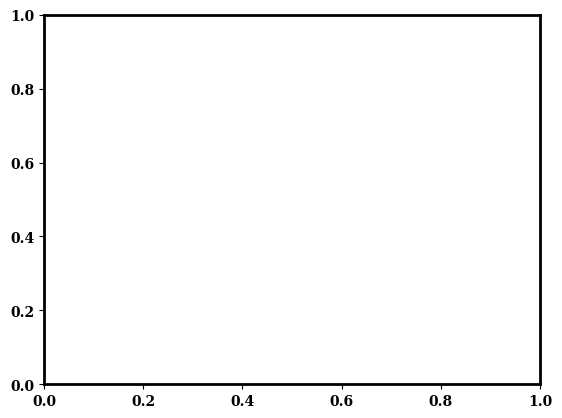

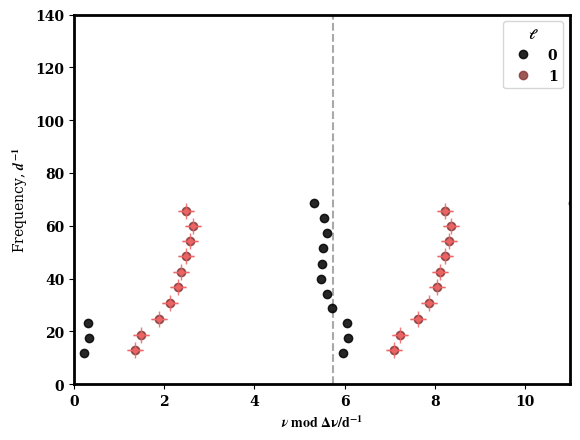

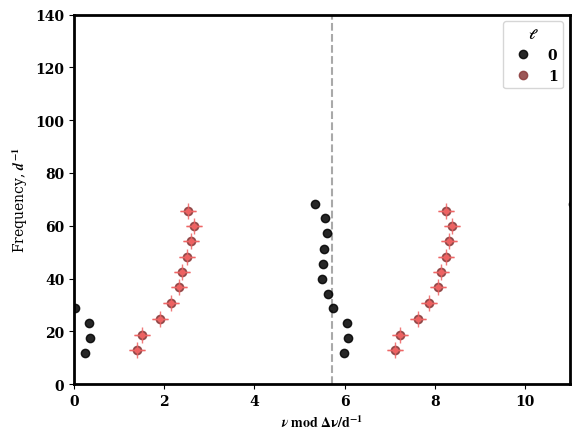

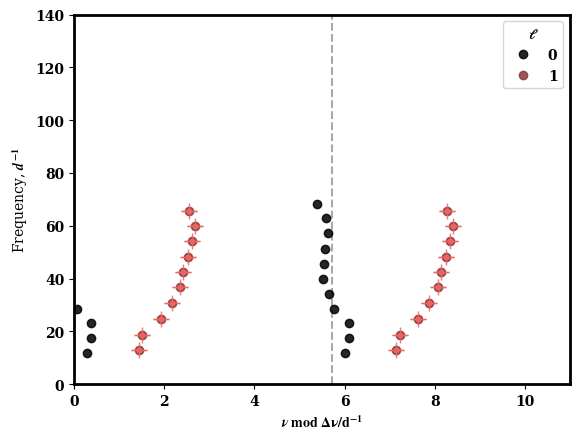

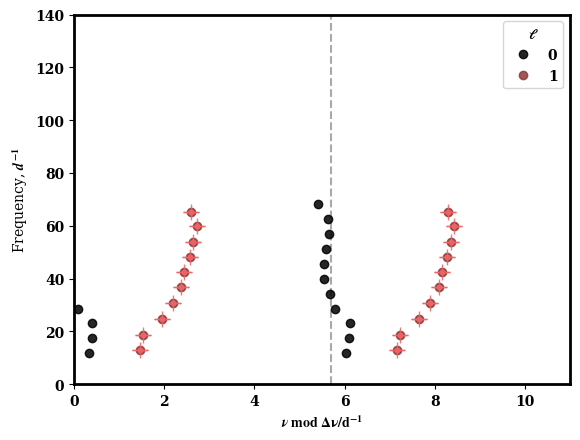

In [18]:
def plot_echelle(hist, freqs, k, index):
        plt.cla()
        freq = freqs[k]
        freq_ = freq[np.logical_and(freq.n_p >= 5, freq.n_p <= 9)]
        fig, ax = plt.subplots()
        nu_max = hist.nu_max.values[-1]
        freq = freq[freq['Re(freq)'] < 5/3*nu_max]
        colors = ('black', '#8B3A3A')
        colors2 = ('#EE6363', '#8B3A3A', '#EE6363')
        for ell in np.unique(freq.l.values):
                Dnu, epsilon = get_fit(ell, freq_)
                nus = freq[freq.l == ell]
                if ell == 0:
                        x = np.append(nus['Re(freq)']%Dnu, nus['Re(freq)']%Dnu + Dnu)
                        y = np.append(nus['Re(freq)'], nus['Re(freq)'])
                        plt.plot(x, y, 'o', 
                                mfc=colors[ell], mec=colors[ell], alpha=0.85,
                                ms=6, mew=1, 
                                label=str(ell))
                else:
                        nus = nus[np.logical_and(nus.n_p >= 1, nus.n_p <= 9)]
                        nu_m0 = nus[nus.m == 0]['Re(freq)'].values
                        x = np.append(nu_m0%Dnu, nu_m0%Dnu + Dnu)
                        y = np.append(nu_m0, nu_m0)
                        plt.plot(x, y, 'o',
                                mfc=colors2[1], mec=colors2[1], alpha=0.85,
                                ms=6, mew=1,
                                label=str(ell))

                        nu_m1 = nus[nus.m == 1]['Re(freq)'].values
                        x = np.append(nu_m1%Dnu, nu_m1%Dnu + Dnu)
                        y = np.append(nu_m1, nu_m1)
                        plt.plot(x, y, '+',
                                mfc=colors2[2], mec=colors2[2], alpha=0.85,
                                ms=12, mew=1)
                        plt.plot(x, y, 'o',
                                mfc=colors2[2], mec=colors2[2], alpha=0.85,
                                ms=3, mew=1)
                        
                        nu_m_1 = nus[nus.m == -1]['Re(freq)'].values
                        x = np.append(nu_m_1%Dnu, nu_m_1%Dnu + Dnu)
                        y = np.append(nu_m_1, nu_m_1)
                        plt.plot(x, y, '_',
                                mfc=colors2[0], mec=colors2[0], alpha=0.85,
                                ms=12, mew=1)
                        plt.plot(x, y, 'o',
                                mfc=colors2[0], mec=colors2[0], alpha=0.85,
                                ms=3, mew=1)
        plt.legend(title='$\u2113$', loc='upper right')

        plt.axvline(Dnu, ls='--', c='darkgray', zorder=-99)

        plt.ylim([0, 140])
        plt.xlim([0, 11])

        plt.ylabel(r'Frequency, $d^{-1}$')
        plt.xlabel(r'$\nu\; \rm{mod}\; \Delta\nu/d^{-1}$')
        # plt.title(f'V={v[v_i]} km/s', size=20)


# plot_echelle(4)

logs_dir = "test/m1.4_z0.024_v0_netbasic/LOGS"
plot_echelle(logs_dir)
# plt.savefig(f"{logs_dir}/echelle/echelle_v_{v[i]}.png", dpi=300)
plt.show()

In [2]:
logs_dir = "test/m1.4_z0.024_v0_netbasic/LOGS"
# fig = plt.figure()
hist, freqs, profs, n_profs, prof_index = get_data(logs_dir)
models = [i[0] for i in prof_index if i[2] in n_profs]
indexes = hist.index[hist.model_number.isin(models)]

# ani = FuncAnimation(fig, plot_echelle, logs_dir)
# plt.show()

NameError: name 'get_data' is not defined